In [14]:

import tensorflow as tf
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
import pickle
 
def save_weights(classifier: LwPClassifier, feature_reducer: FeatureReducer, filename: str = "weights.pkl"):
    """Save classifier prototypes and PCA components."""
    weights = {
        "prototypes": classifier.prototypes,
        "pca_components": feature_reducer.pca.components_,
        "pca_mean": feature_reducer.pca.mean_
    }
    with open(filename, "wb") as f:
        pickle.dump(weights, f)
    print(f"Weights saved to {filename}")
    
# Step 1: Load the dataset
def load_dataset(filepath: str):
    """Loads a dataset from a given file path."""
    t = torch.load(filepath)
    data, targets = t['data'], t.get('targets')  # Targets may be None for unlabeled data
    return data, targets

# Step 2: Feature Extraction with ResNet50
class ResNet50FeatureExtractor:
    def __init__(self, input_shape=(112, 112, 3)):
        # Load ResNet50 without the top classification layer
        self.model = tf.keras.applications.ResNet50(
            weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape
        )

    def preprocess(self, data: np.ndarray):
        """Preprocess raw image data to match ResNet50 input requirements."""
        data = data.astype(np.float32)
        resized_data = np.array([tf.image.resize(img, (112, 112)).numpy() for img in data])
        preprocessed_data = tf.keras.applications.resnet50.preprocess_input(resized_data)
        return preprocessed_data

    def extract(self, data: np.ndarray):
        """Extract features using ResNet50."""
        preprocessed_data = self.preprocess(data)
        features = self.model.predict(preprocessed_data, batch_size=32, verbose=1)
        return features

# Step 3: Dimensionality Reduction
class FeatureReducer:
    def __init__(self, n_components=256):
        self.pca = PCA(n_components=n_components)

    def fit_transform(self, data: np.ndarray):
        return self.pca.fit_transform(data)

    def transform(self, data: np.ndarray):
        return self.pca.transform(data)

# Step 4: LwP Classifier with Regularization
class LwPClassifier:
    def __init__(self, num_classes: int, lambda_reg=0.1):
        self.num_classes = num_classes
        self.prototypes = None
        self.lambda_reg = lambda_reg  # Regularization strength

    def fit(self, data: np.ndarray, labels: np.ndarray):
        """Initialize prototypes based on labeled data.""" 
        self.prototypes = []
        for cls in range(self.num_classes):
            cls_data = data[labels == cls]
            if len(cls_data) > 0:
                cls_prototype = cls_data.mean(axis=0)
                self.prototypes.append(cls_prototype)
        self.prototypes = np.array(self.prototypes)

    def predict(self, data: np.ndarray):
        """Predict labels for the given data."""
        distances = cdist(data, self.prototypes)
        return np.argmin(distances, axis=1)

    def update(self, data: np.ndarray, pseudo_labels: np.ndarray, alpha=0.7):
        """Update prototypes using pseudo-labeled data with regularization."""
        for cls in range(self.num_classes):
            cls_data = data[pseudo_labels == cls]
            if len(cls_data) > 0:
                cls_mean = cls_data.mean(axis=0)
                # Regularized update
                self.prototypes[cls] = (alpha * self.prototypes[cls] + (1 - alpha) * cls_mean) - \
                                       self.lambda_reg * (self.prototypes[cls] - cls_mean)
import matplotlib.pyplot as plt

def plot_pca_variance(feature_reducer):
    """Plot the cumulative explained variance by PCA components."""
    explained_variance = feature_reducer.pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance), marker='o')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid()
    plt.show()

def plot_prototype_distances(prototypes_list):
    """Plot the distances between prototypes over training epochs."""
    distances = [
        np.linalg.norm(prototypes_list[epoch] - prototypes_list[epoch - 1], axis=1).mean()
        for epoch in range(1, len(prototypes_list))
    ]
    plt.figure(figsize=(10, 6))
    plt.plot(distances, marker='o')
    plt.title("Prototype Distance Evolution Over Training Epochs")
    plt.xlabel("Training Epoch")
    plt.ylabel("Average Prototype Distance")
    plt.grid()
    plt.show()

def train_and_evaluate(train_files: list, eval_files: list, num_classes=10):
    """
    Train iteratively on datasets (D1, D2, ..., Dn) and evaluate on all datasets after each training step.
    Datasets without targets will use pseudo-labels generated by the classifier.
    """
    n = len(train_files)  # Number of datasets
    accuracies = np.zeros((n, n))  # Accuracy matrix (n x n): Train on Di, evaluate on Dj
    
    # Feature extractor and dimensionality reducer
    feature_extractor = ResNet50FeatureExtractor()
    feature_reducer = FeatureReducer()
    classifier = LwPClassifier(num_classes=num_classes)
    
    # Storage for reduced features, targets, and prototypes for plotting
    reduced_features_list = []
    targets_list = []
    prototypes_list = []  # To track prototypes after each dataset

    for i in range(n):
        # Load training dataset
        data, targets = load_dataset(train_files[i])
        print(f"Training on dataset D{i+1}: Data shape {data.shape}")
        
        # Check if targets are available
        if targets is None:
            print(f"Dataset D{i+1} does not have targets; using pseudo-labeling.")
        
        # Extract features
        features = feature_extractor.extract(data)
        
        # Fit PCA on the first dataset and transform all others
        if i == 0:
            reduced_features = feature_reducer.fit_transform(features)
        else:
            reduced_features = feature_reducer.transform(features)

        # Generate pseudo-labels if targets are not available
        if targets is None:
            pseudo_labels = classifier.predict(reduced_features)
            classifier.update(reduced_features, pseudo_labels)  # Update prototypes using pseudo-labels
        else:
            targets = np.array(targets)
            classifier.fit(reduced_features, targets)  # Fit with actual labels

        # Store reduced features and targets/pseudo-labels for future evaluations
        reduced_features_list.append(reduced_features)
        targets_list.append(targets if targets is not None else pseudo_labels)
        
        # Save prototypes for plotting
        prototypes_list.append(np.copy(classifier.prototypes))  # Save a copy of prototypes at this step
        
        # Save weights after training
        save_weights(classifier, feature_reducer, filename="trained_weights.pkl")
        
        # Evaluate on all datasets seen so far (D1 to Di)
        for j in range(i + 1):
            eval_features = reduced_features_list[j]
            eval_targets = targets_list[j]
            predictions = classifier.predict(eval_features)
            accuracies[i, j] = accuracy_score(eval_targets, predictions)
            print(f"Evaluated on dataset D{j+1}: Accuracy = {accuracies[i, j]:.4f}")
    
    return accuracies, feature_reducer, classifier, prototypes_list


# Example usage
train_files = [f"dataset/part_one_dataset/train_data/{i}_train_data.tar.pth" for i in range(1, 11)]
eval_files = [f"dataset/part_one_dataset/eval_data/{i}_eval_data.tar.pth" for i in range(1, 11)]
accuracies, feature_reducer, classifier, prototypes_list = train_and_evaluate(train_files, eval_files)


print("Accuracy matrix:")
print(accuracies)




Training on dataset D1: Data shape (2500, 32, 32, 3)
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 377ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.7760
Training on dataset D2: Data shape (2500, 32, 32, 3)
Dataset D2 does not have targets; using pseudo-labeling.
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 356ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.7592
Evaluated on dataset D2: Accuracy = 0.9744
Training on dataset D3: Data shape (2500, 32, 32, 3)
Dataset D3 does not have targets; using pseudo-labeling.
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.7396
Evaluated on dataset D2: Accuracy = 0.9428
Evaluated on dataset D3: Accuracy = 0.9684
Training on dataset D4: Data shape (2500, 32, 32, 3)
Dataset D4 does not have targets; using pseudo-labeling.
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 384ms/step
Weights saved to trained_weights.pkl
Evaluated on dataset D1: Accuracy = 0.7248


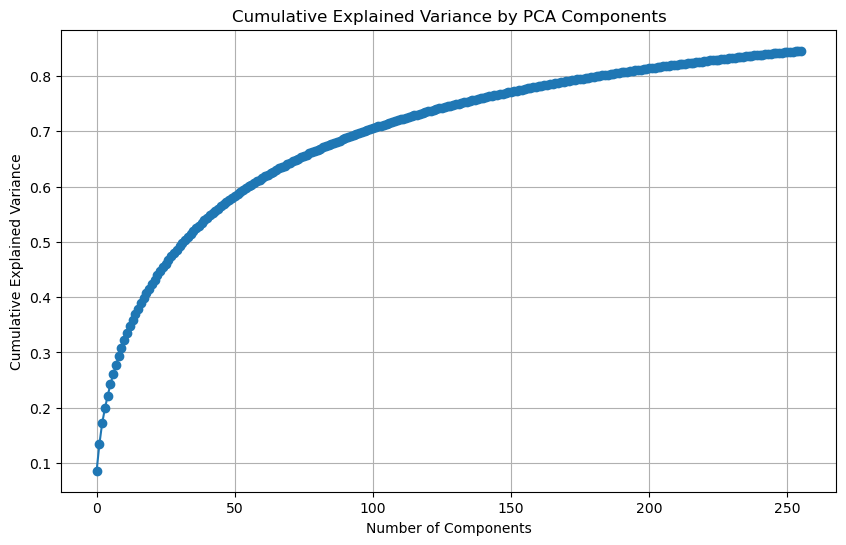

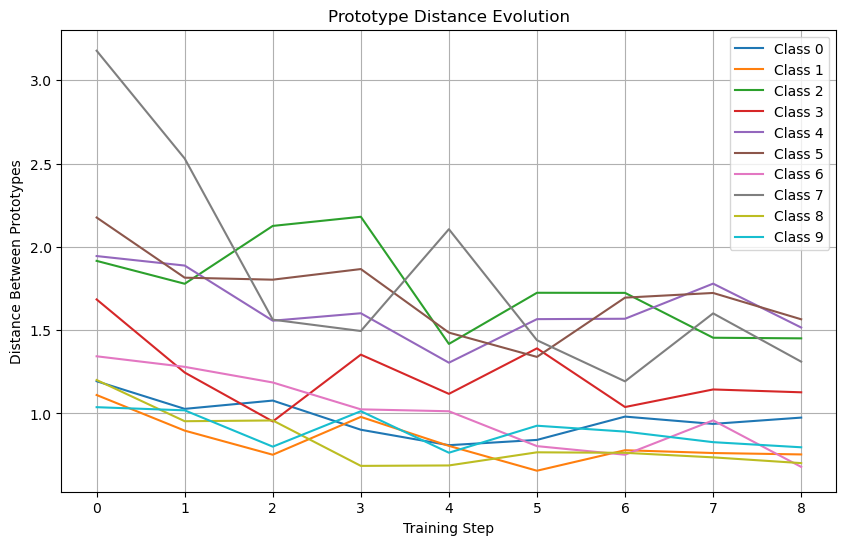

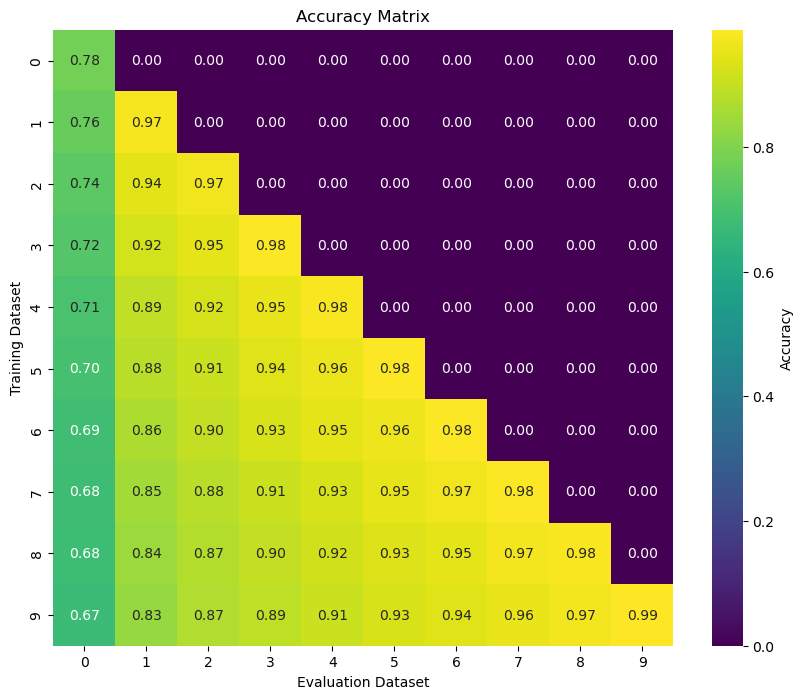

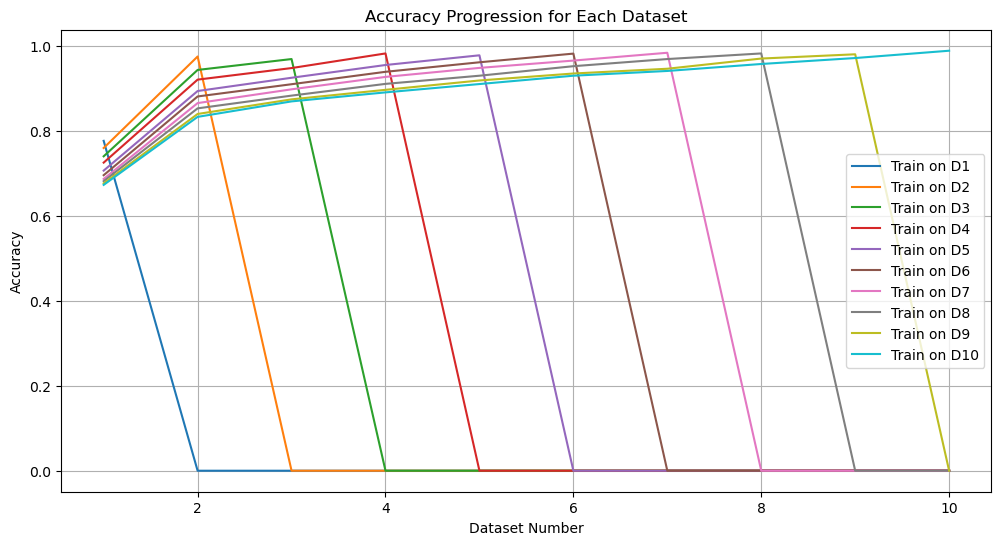

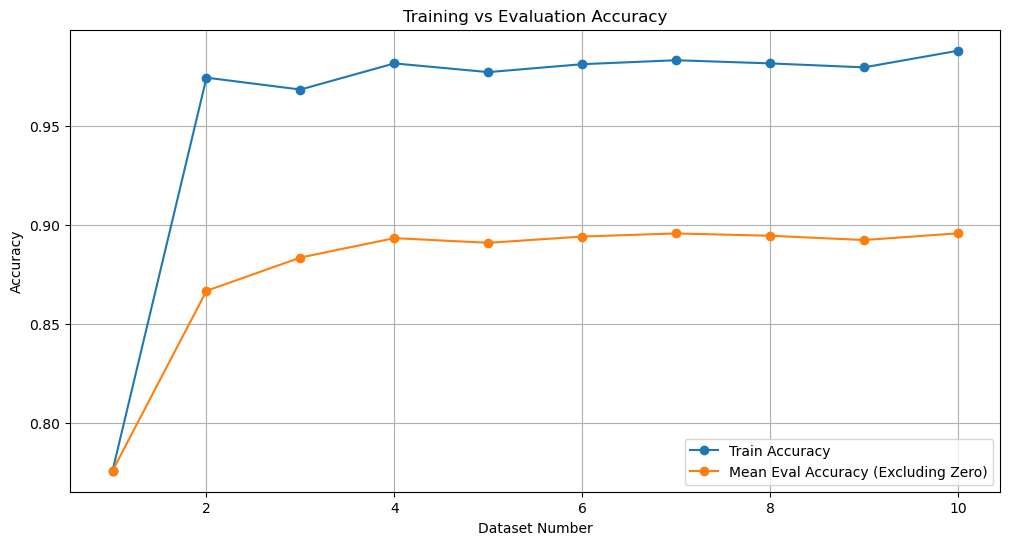

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Accuracy Matrix Heatmap
def plot_accuracy_matrix(accuracies):
    plt.figure(figsize=(10, 8))
    sns.heatmap(accuracies, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
    plt.title("Accuracy Matrix")
    plt.xlabel("Evaluation Dataset")
    plt.ylabel("Training Dataset")
    plt.show()

# 2. Accuracy Progression per Dataset
def plot_accuracy_progression(accuracies):
    n = accuracies.shape[0]
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(range(1, n + 1), accuracies[i], label=f"Train on D{i+1}")
    plt.title("Accuracy Progression for Each Dataset")
    plt.xlabel("Dataset Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Plot results
plot_pca_variance(feature_reducer)  # Plot PCA variance explained
plot_prototype_distances(prototypes_list)  # Plot prototype distance evolution



# 4. Prototype Distance Evolution
def plot_prototype_distances(prototypes_list):
    distances = []
    for i in range(len(prototypes_list) - 1):
        dist = np.linalg.norm(prototypes_list[i] - prototypes_list[i + 1], axis=1)
        distances.append(dist)
    distances = np.array(distances).T

    plt.figure(figsize=(10, 6))
    for cls in range(distances.shape[0]):
        plt.plot(distances[cls], label=f"Class {cls}")
    plt.title("Prototype Distance Evolution")
    plt.xlabel("Training Step")
    plt.ylabel("Distance Between Prototypes")
    plt.legend()
    plt.grid()
    plt.show()

# 5. Evaluation Comparison
def plot_evaluation_comparison(accuracies):
    train_accuracies = np.diagonal(accuracies)
    
    # Compute mean evaluation accuracies excluding zeros
    mean_eval_accuracies = [
        np.mean(row[row != 0]) if np.any(row != 0) else 0 
        for row in accuracies
    ]
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
    plt.plot(range(1, len(mean_eval_accuracies) + 1), mean_eval_accuracies, marker='o', label="Mean Eval Accuracy (Excluding Zero)")
    plt.title("Training vs Evaluation Accuracy")
    plt.xlabel("Dataset Number")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


# Example Visualization Calls
plot_accuracy_matrix(accuracies)  # Plot the accuracy matrix
plot_accuracy_progression(accuracies)  # Plot accuracy progression
# Assuming `feature_reducer` and `classifier` objects are accessible
# plot_pca_variance(feature_reducer)  # Plot PCA variance explained
# Assuming you collect prototypes during training
# plot_prototype_distances(prototypes_list)  # Prototype distance evolution
plot_evaluation_comparison(accuracies)  # Training vs Evaluation accuracy comparison
